In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio


### create spikes df

In [2]:
# pull in QC
df_preproc = pd.read_csv('../../results/202512/preproc.csv')[['channel', 'unit', 'keep']]
df_preproc['keep'] = df_preproc['keep'].fillna(0)
df_preproc

,channel,unit,keep
0,1.0,596.0,0.0
1,1.0,612.0,0.0
2,2.0,1432.0,0.0
3,2.0,1502.0,0.0
4,2.0,1543.0,0.0
...,...,...,...
86,31.0,182.0,0.0
87,31.0,188.0,0.0
88,32.0,167.0,0.0
89,32.0,174.0,0.0


In [3]:
# get [clustIDs] where df[keep] = 0
dropped_clustIDs = df_preproc[df_preproc['keep'] != 1]['unit'].tolist()
dropped_clustIDs.extend([0, 99999999])
print(dropped_clustIDs)

[596.0, 612.0, 1432.0, 1502.0, 1543.0, 506.0, 703.0, 636.0, 683.0, 1469.0, 2405.0, 2423.0, 2457.0, 2481.0, 1518.0, 1755.0, 1348.0, 1396.0, 1553.0, 1566.0, 1715.0, 1772.0, 976.0, 1042.0, 1045.0, 1433.0, 1799.0, 1825.0, 1953.0, 1712.0, 2185.0, 2769.0, 3203.0, 3227.0, 2308.0, 2323.0, 264.0, 571.0, 1998.0, 1747.0, 1901.0, 1921.0, 1585.0, 1736.0, 1558.0, 2261.0, 2280.0, 1663.0, 1678.0, 1373.0, 1882.0, 130.0, 147.0, 82.0, 117.0, 141.0, 163.0, 157.0, 172.0, 148.0, 151.0, 118.0, 156.0, 182.0, 188.0, 167.0, 174.0, nan, 0, 99999999]


In [4]:
def get_ID_spikes_dict(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    ID_spikes_dict = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in ID_spikes_dict: ID_spikes_dict[clustID] = [] # init

        ID_spikes_dict[clustID].append(spike)

    return ID_spikes_dict

In [5]:
samp_rate = 1000000
spikes_df = []

data_dir = '../../results/202512/osort_mat/sort/5'
for channel_num in range(len(os.listdir(data_dir))):

    channel_mat = sio.loadmat(f'{data_dir}/A{channel_num+1}_sorted_new.mat')

    # get (1 * n_spikes) clusterID & spiketimes
    clust_IDs = channel_mat['assignedNegative'][0]
    spikes = channel_mat['newTimestampsNegative'][0]

    # get clusterID: [spikes]
    ID_spikes_dict = get_ID_spikes_dict(clust_IDs, spikes)

    # 1 row per clustID
    clust_df = pd.DataFrame([
        {
            "channel": channel_num + 1,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in ID_spikes_dict.items()
    ])
    spikes_df.append(clust_df)

    # if channel_num > 10: break

spikes_df = pd.concat(spikes_df, ignore_index=True)


In [6]:
print(len(spikes_df))
eg_spikes = spikes_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
spikes_df

23
last 5 spikes (s): [1620.1233     1620.19223333 1620.53116667 1620.94453333 1621.08233333]
last 5 spikes (min): [27.002055   27.00320389 27.00885278 27.01574222 27.01803889]


,channel,clustID,spikes,#spikes,avgFR
0,2,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
1,5,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
2,6,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
3,6,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
4,6,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
5,7,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
6,8,2410,"[2.8733333333333335, 3.5848333333333335, 3.852...",2370,1.465269
7,8,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847
8,9,1938,"[0.6124666666666667, 0.7821333333333333, 1.033...",8664,5.346766
9,9,1892,"[2.8222333333333336, 4.503333333333334, 5.6112...",3353,2.076493


### psychopy

In [7]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj_df = df_subjs[df_subjs['subj'] == '12'].copy()
subj_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,0.0,0.224,0.2,0.34,1.0,1.0,0.0,-0.116,0.116,...,NaN,NaN,NaN,NaN,NaN,False,False,False,34.5,20.0
236,0.0,0.0,0.292,0.2,0.38,1.0,1.0,0.0,-0.088,0.088,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,32.0
237,1.0,0.0,0.252,0.2,0.38,1.0,1.0,0.0,-0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,23.5
238,0.0,0.0,0.384,0.2,0.38,1.0,1.0,0.0,0.004,0.004,...,NaN,NaN,NaN,NaN,NaN,False,False,False,38.5,38.0


In [8]:
phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
phase_bounds_dict = {}

for phase in phases:

    # e.g., baseline: ['baseline.started', 'baseline.stopped']
    phase_bounds_dict[phase] = [f'{phase}.started', f'{phase}.stopped']

    # # optional. sid, check
    # if phase == 'stim': phase_bounds_dict[phase] = [f'target_stim.started', f'{phase}.stopped']
    # if phase == 'feedback': phase_bounds_dict[phase] = [f'no_resp_text.started', f'{phase}.stopped']

phase_cols = []
for key, val in phase_bounds_dict.items():
    phase_cols.extend(val)
    print(f'{key}: {val}')

subj_df[phase_cols]

baseline: ['baseline.started', 'baseline.stopped']
stim: ['stim.started', 'stim.stopped']
delay: ['delay.started', 'delay.stopped']
task: ['task.started', 'task.stopped']
anticipation: ['anticipation.started', 'anticipation.stopped']
feedback: ['feedback.started', 'feedback.stopped']


,baseline.started,baseline.stopped,stim.started,stim.stopped,delay.started,delay.stopped,task.started,task.stopped,anticipation.started,anticipation.stopped,feedback.started,feedback.stopped
0,179.287941,180.223108,180.223534,181.220776,181.221150,182.505846,182.507335,183.771864,183.772263,184.020854,184.021192,185.020908
1,223.455750,224.339824,224.340248,225.338597,225.338994,226.824359,226.825565,228.122857,228.123211,228.372063,228.372396,229.372133
2,84.668625,85.654174,85.654526,86.651546,86.651923,88.135832,88.137054,89.735787,89.736143,89.984966,89.985295,90.985009
3,129.803268,130.788351,130.789024,131.786087,131.786473,133.121612,133.123205,134.437185,134.437590,134.686145,134.686486,135.686205
4,72.568310,73.453843,73.454512,74.451224,74.451600,75.936204,75.937423,77.035449,77.035813,77.284656,77.285009,78.284667
...,...,...,...,...,...,...,...,...,...,...,...,...
235,1523.824445,1524.759799,1524.760366,1525.757295,1525.757669,1527.092060,1527.093282,1528.724787,1528.725147,1528.974048,1528.974373,1529.974116
236,1418.888245,1419.773327,1419.773661,1420.771101,1420.771475,1422.105695,1422.107137,1423.738572,1423.738923,1423.987802,1423.988133,1424.987862
237,1559.742073,1560.727593,1560.728215,1561.724937,1561.725308,1563.010160,1563.011427,1564.192590,1564.192956,1564.441677,1564.442014,1565.441714
238,1407.721291,1408.655590,1408.655942,1409.654137,1409.654537,1410.939023,1410.940716,1411.888314,1411.888668,1412.137453,1412.137788,1413.137560


### get FRs

In [11]:
def get_phase_FRs(subj_df, spikes_df, phase, prestart=-.5, stop=1, size=.2, step=.05):
    ''' return 3d array of trial x neuron x binned FRs for given phase '''
    
    if phase == 'baseline': prestart = .3 # to prevent spillover from feedback
    n_bins = int((stop - prestart - size) / step) + 1 # ?

    # 3d arr
    trial_neur_bin = np.zeros((len(subj_df), len(spikes_df), n_bins))

    for trial_i, trial_row in subj_df.iterrows():

        trial_phase_onset = trial_row[f'{phase}.started']

        for neur_i, neur_row in spikes_df.iterrows():

            spike_train = np.zeros(n_bins)

            # phase spike times, aligned
            trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= trial_phase_onset + prestart) &
                                                    (neur_row['spikes'] <= trial_phase_onset + stop)]
            trial_phase_spikes = trial_phase_spikes - trial_phase_onset

            # sliding window
            for bin in range(n_bins):
                bin_start, bin_stop = prestart + bin*step, prestart + bin*step + size
                bin_spikes = trial_phase_spikes[(trial_phase_spikes >= bin_start) & (trial_phase_spikes < bin_stop)]
                spike_train[bin] = len(bin_spikes) / size

            # for this trial and neuron, store smoothed FRs across bins
            trial_neur_bin[trial_i, neur_i, :] = spike_train

    return trial_neur_bin

# bin params
prestart, stop, size, step = -.5, 1, .2, .05
n_bins = int((stop - prestart - size) / step) + 1
bin_mid_pts = np.linspace(prestart + size/2, stop - size/2, n_bins) # for plotting

# for norming
base_FRs = get_phase_FRs(subj_df, spikes_df, 'baseline', prestart=prestart, stop=stop, size=size, step=step)
# trial & bin avg
neur_base_FR = base_FRs.mean(axis=(0,2))  # shape = (n_neurons,)


In [30]:
outcome_FRs = get_phase_FRs(subj_df, spikes_df, 'feedback', prestart=prestart, stop=stop, size=size, step=step)
outcome_FRs_normed = outcome_FRs / neur_base_FR[np.newaxis, :, np.newaxis]

stimVal_FRs = get_phase_FRs(subj_df, spikes_df, 'stim', prestart=prestart, stop=stop, size=size, step=step)
stimVal_FRs_normed = stimVal_FRs / neur_base_FR[np.newaxis, :, np.newaxis]

n_trials, n_neurs, n_bins = outcome_FRs_normed.shape
print(f'n_trials, n_neurons, n_bins: {outcome_FRs_normed.shape}')

n_trials, n_neurons, n_bins: (240, 23, 27)


### create conditions

In [52]:
# 1. outcome
out3_ids = subj_df[subj_df['outcome'] == 3].index
out1_ids = subj_df[subj_df['outcome'] == 1].index
print(f'#outcome=3: {len(out3_ids)}, #outcome=1: {len(out1_ids)}')

out3_FRs = np.mean(outcome_FRs_normed[out3_ids, :, :], axis=0)
out1_FRs = np.mean(outcome_FRs_normed[out1_ids, :, :], axis=0)
print(f'#neurs, #bins: {out3_FRs.shape}, {out1_FRs.shape}')
print()

# 2. stimVal
stimPos_ids = subj_df[subj_df['stim_pos_aligned'] > 0].index
stimNeg_ids = subj_df[subj_df['stim_pos_aligned'] < 0].index
print(f'#stimPos: {len(stimPos_ids)}, #stimNeg: {len(stimNeg_ids)}')

stimPos_FRs = np.mean(stimVal_FRs_normed[stimPos_ids, :, :], axis=0)
stimNeg_FRs = np.mean(stimVal_FRs_normed[stimNeg_ids, :, :], axis=0)
print(f'#neurs, #bins: {stimPos_FRs.shape}, {stimNeg_FRs.shape}')
print()

# # 2. stimVal
# # dict: stim_aligned_valence -> np.array(trial_ids)
# stimVal2ids = subj_df.groupby('stim_pos_aligned').indices
# # 12 trials per stim per session
# for stim, ids in stimVal2ids.items(): assert len(ids) == 12

# # stimVal -> stimVal_FRs_normed[stimVal_trial_ids, :, :].mean(axis=0)
# stimVal2FRs = {stimVal: stimVal_FRs_normed[stimVal_trial_ids, :, :].mean(axis=0) for stimVal, stimVal_trial_ids in stimVal2ids.items()}
# for stimVal, stimVal_FRs in stimVal2FRs.items():
#     print('example:')
#     print(f'stimVal {stimVal}: n_neurs, n_bins: {stimVal_FRs.shape}')
#     break


#outcome=3: 113, #outcome=1: 111
#neurs, #bins: (23, 27), (23, 27)

#stimPos: 120, #stimNeg: 120
#neurs, #bins: (23, 27), (23, 27)



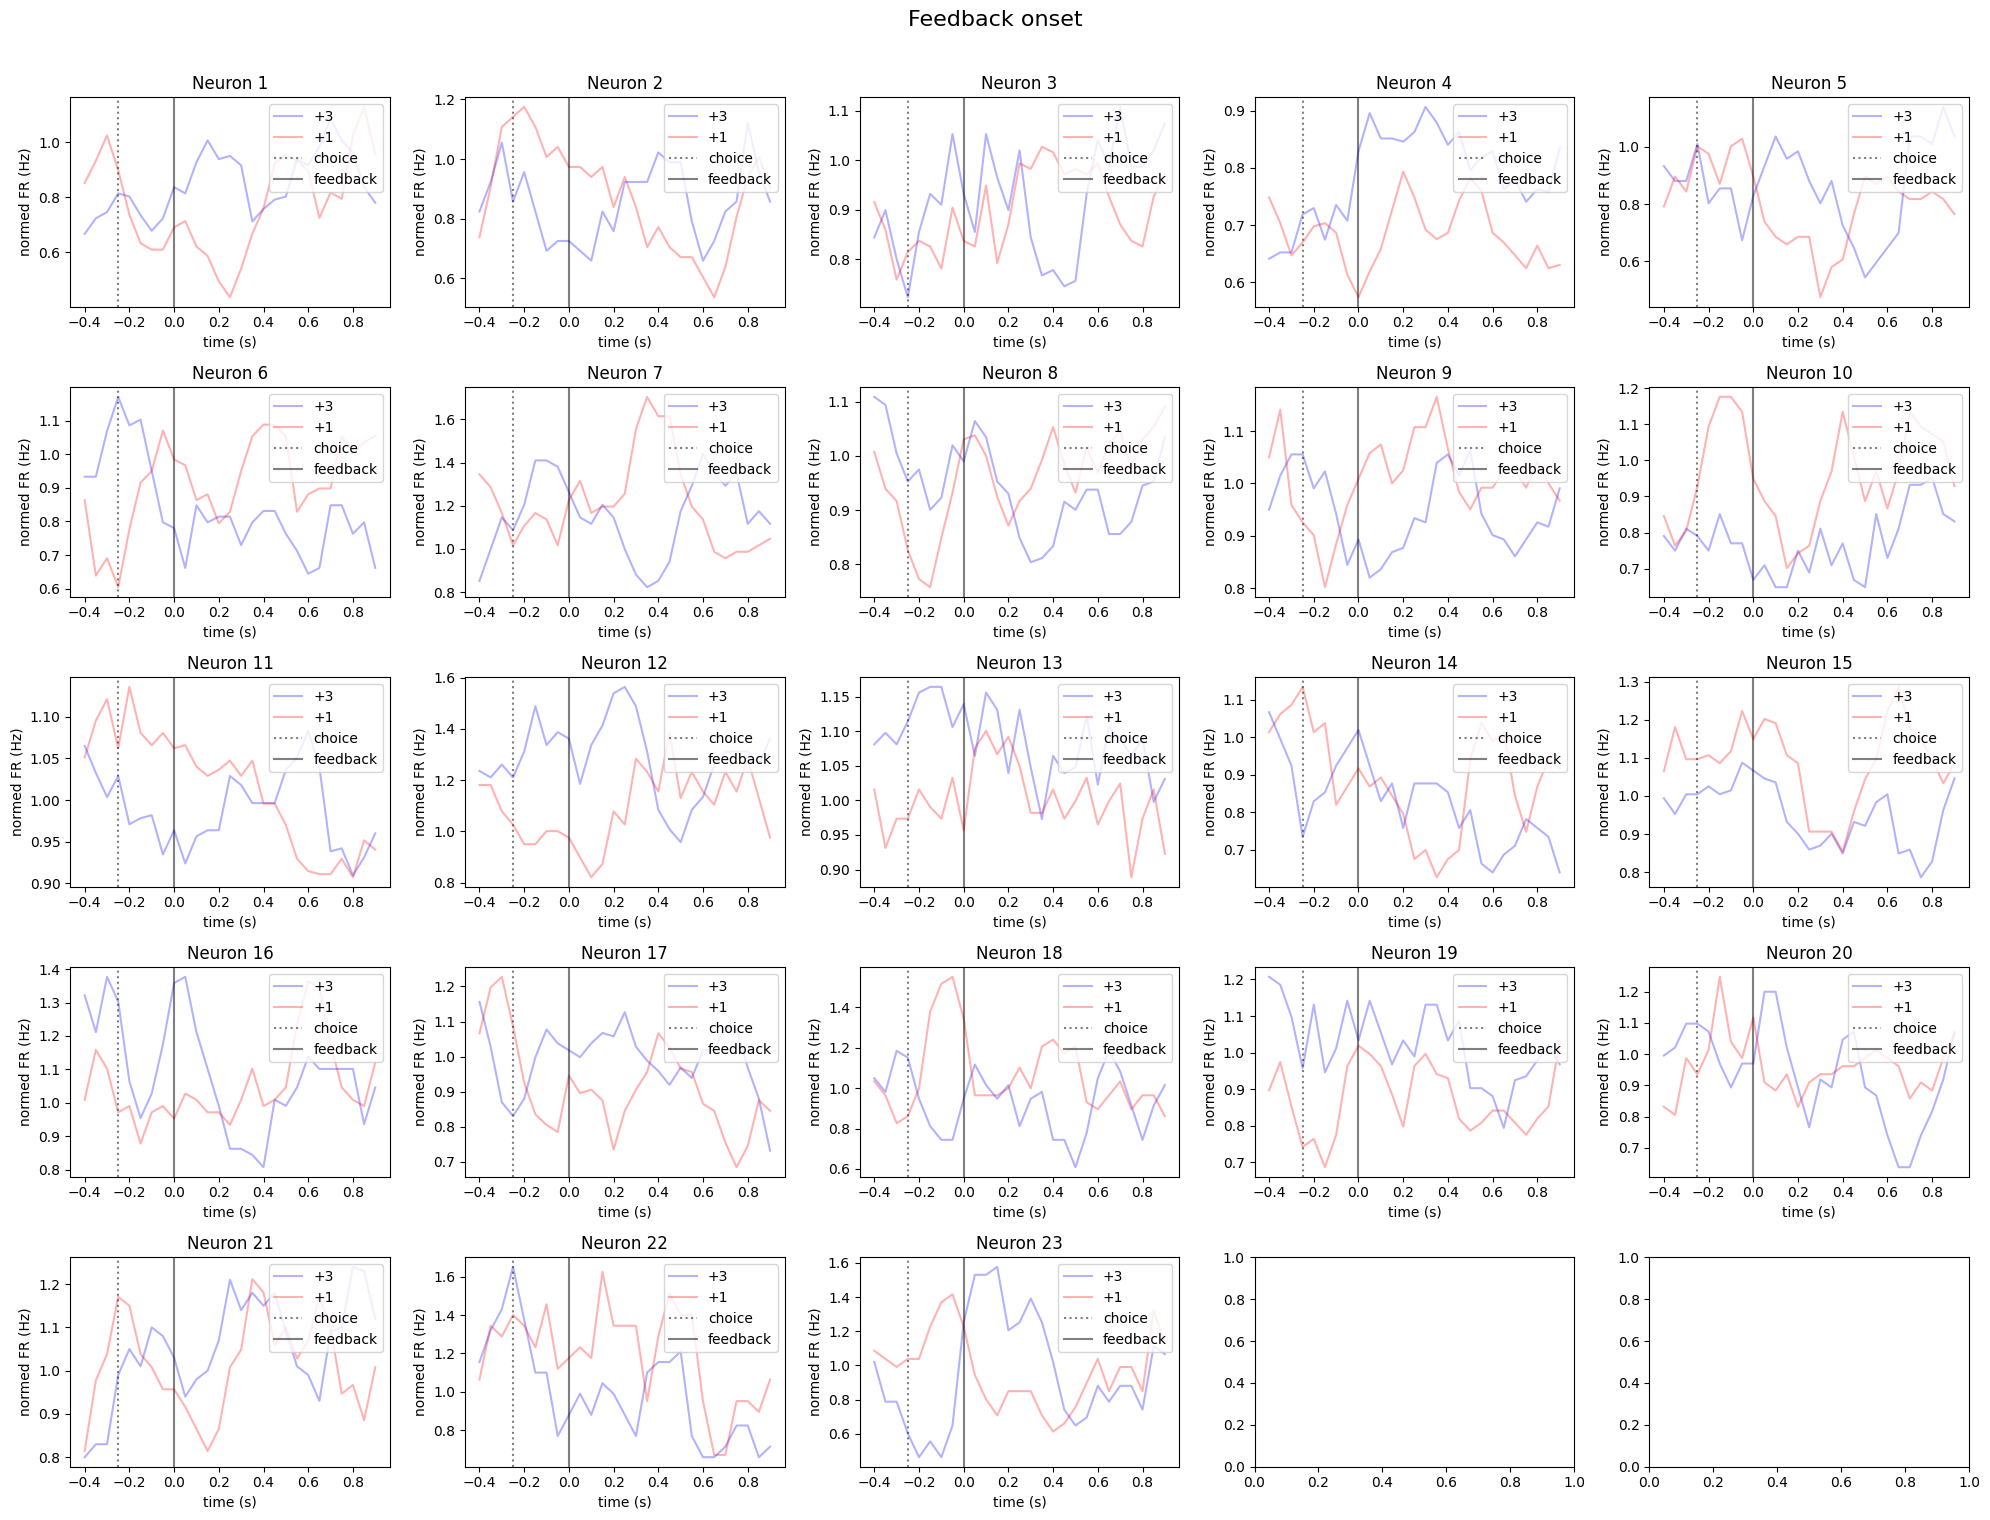

In [53]:
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):
    for outcome, outcome_FRs, color in zip(['+3', '+1'], [out3_FRs, out1_FRs], ['b', 'r']):
        axs[ax].plot(bin_mid_pts, outcome_FRs[neur_i, :], alpha=0.3, color=color, label=outcome)
    axs[ax].axvline(-.25, color='k', linestyle=':', alpha=0.5, label='choice')
    axs[ax].axvline(0, color='k', linestyle='-', alpha=0.5, label='feedback')
    axs[ax].set(title=f'Neuron {neur_i+1}', ylabel='normed FR (Hz)', xlabel='time (s)', xticks=bin_mid_pts)
    axs[ax].set_xticks(bin_mid_pts[::4]) # sparse
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle('Feedback onset', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


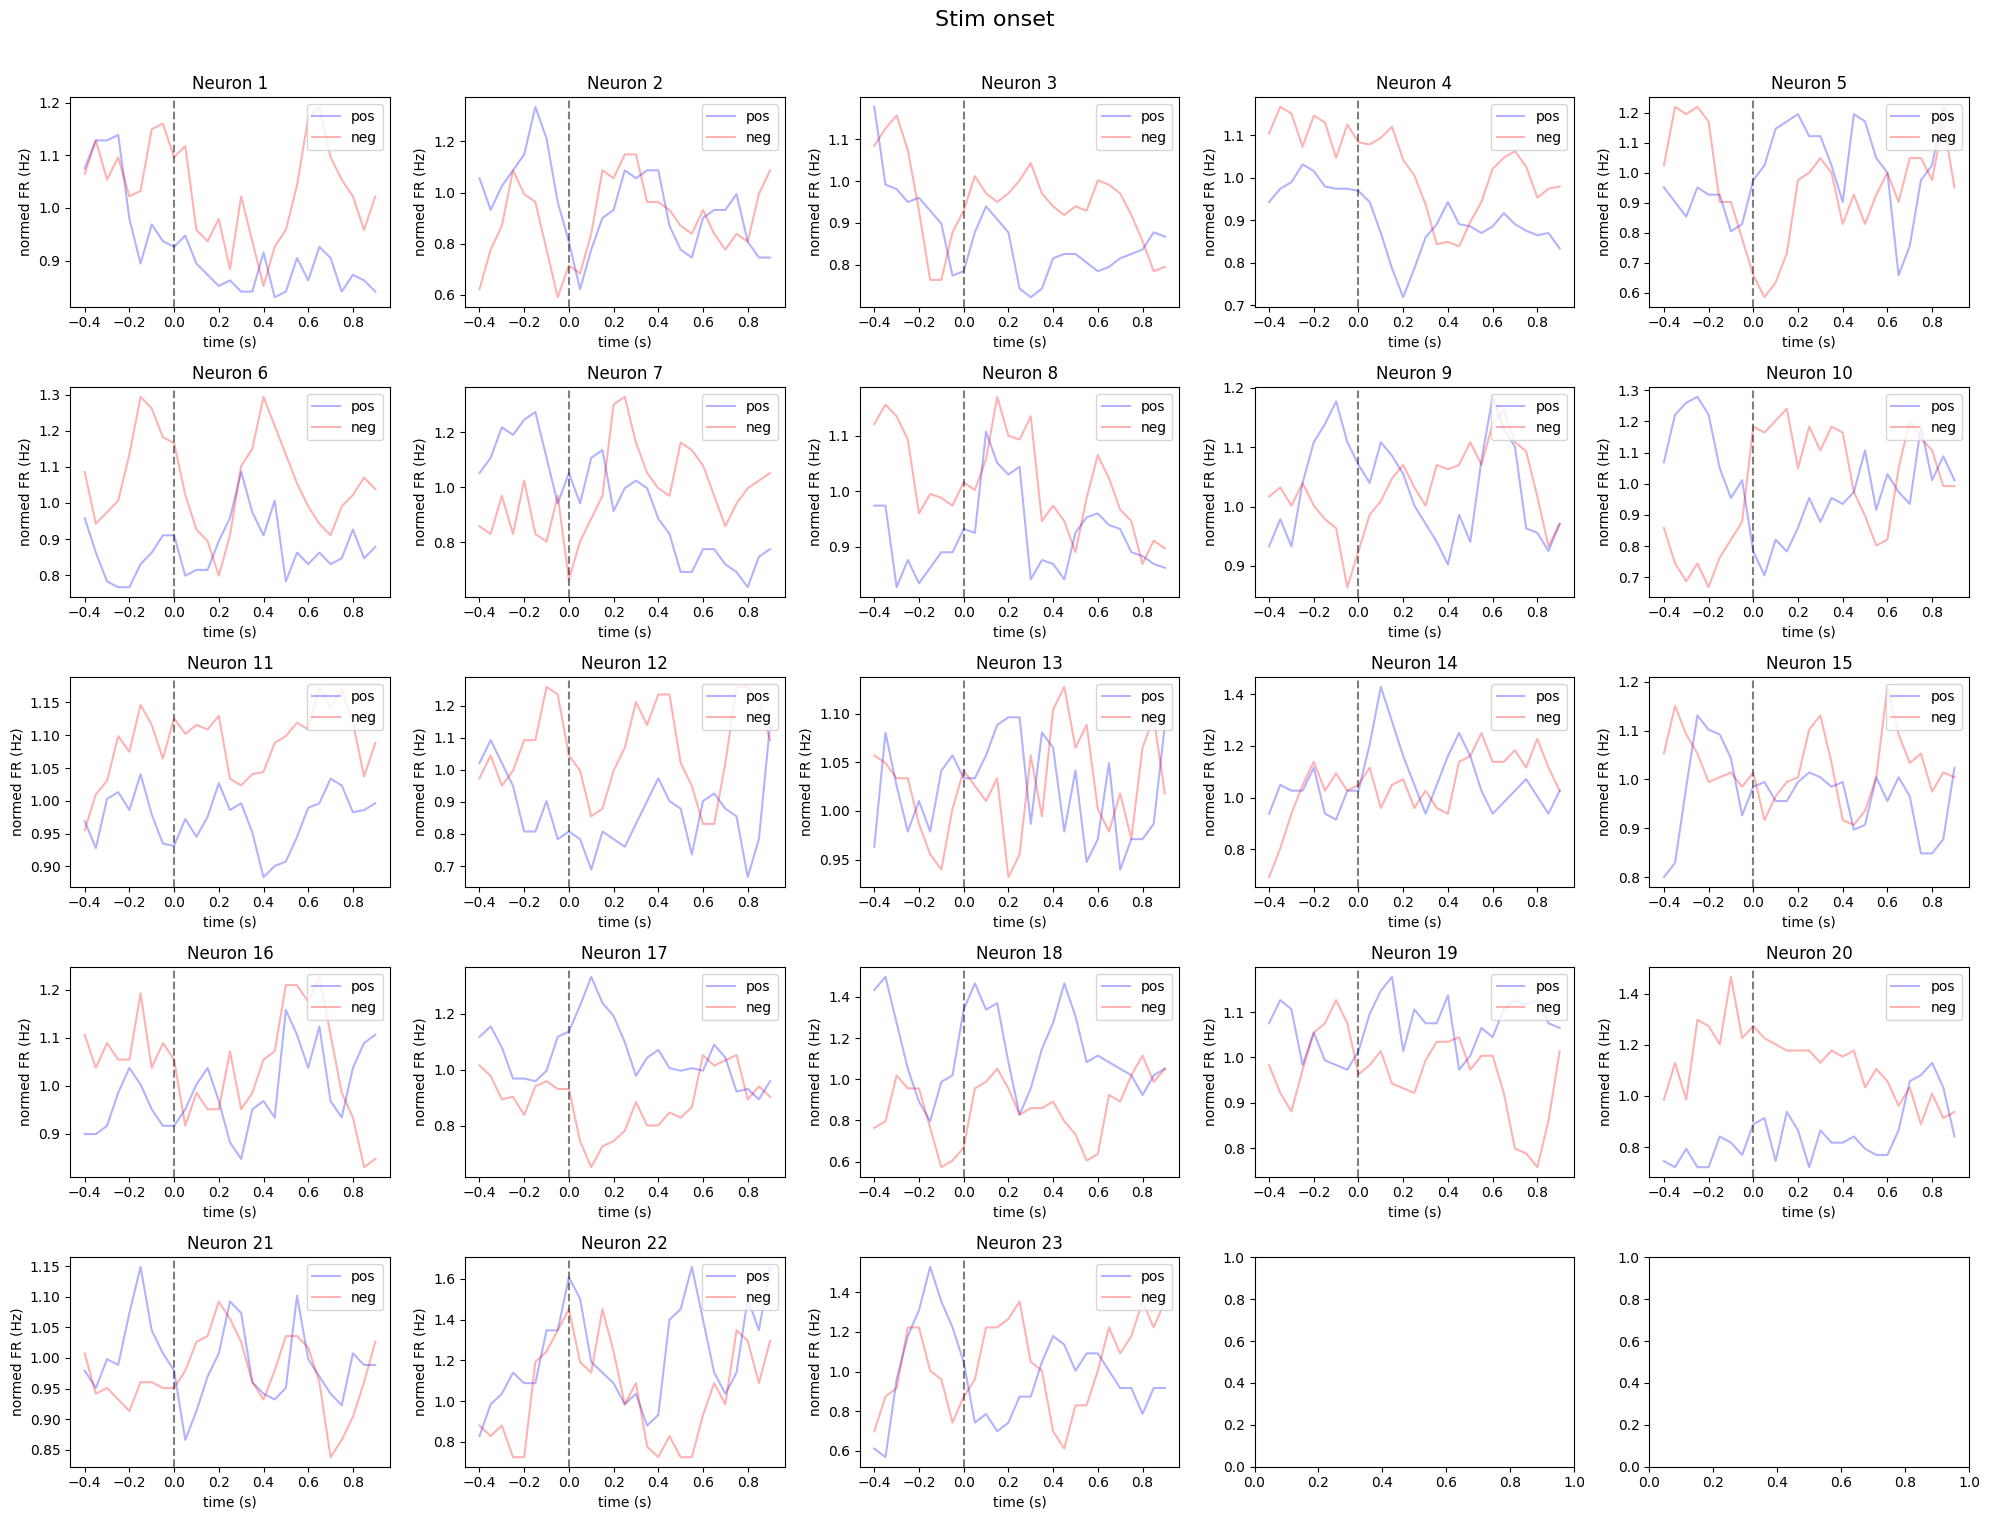

In [57]:
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):
    for stimVal, stimVal_FRs, color in zip(['pos', 'neg'], [stimPos_FRs, stimNeg_FRs], ['b', 'r']):
        axs[ax].plot(bin_mid_pts, stimVal_FRs[neur_i, :], alpha=0.3, color=color, label=stimVal)
    axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'Neuron {neur_i+1}', ylabel='normed FR (Hz)', xlabel='time (s)', xticks=bin_mid_pts)
    axs[ax].set_xticks(bin_mid_pts[::4]) # sparse
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle('Stim onset', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3891054/2245984613.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


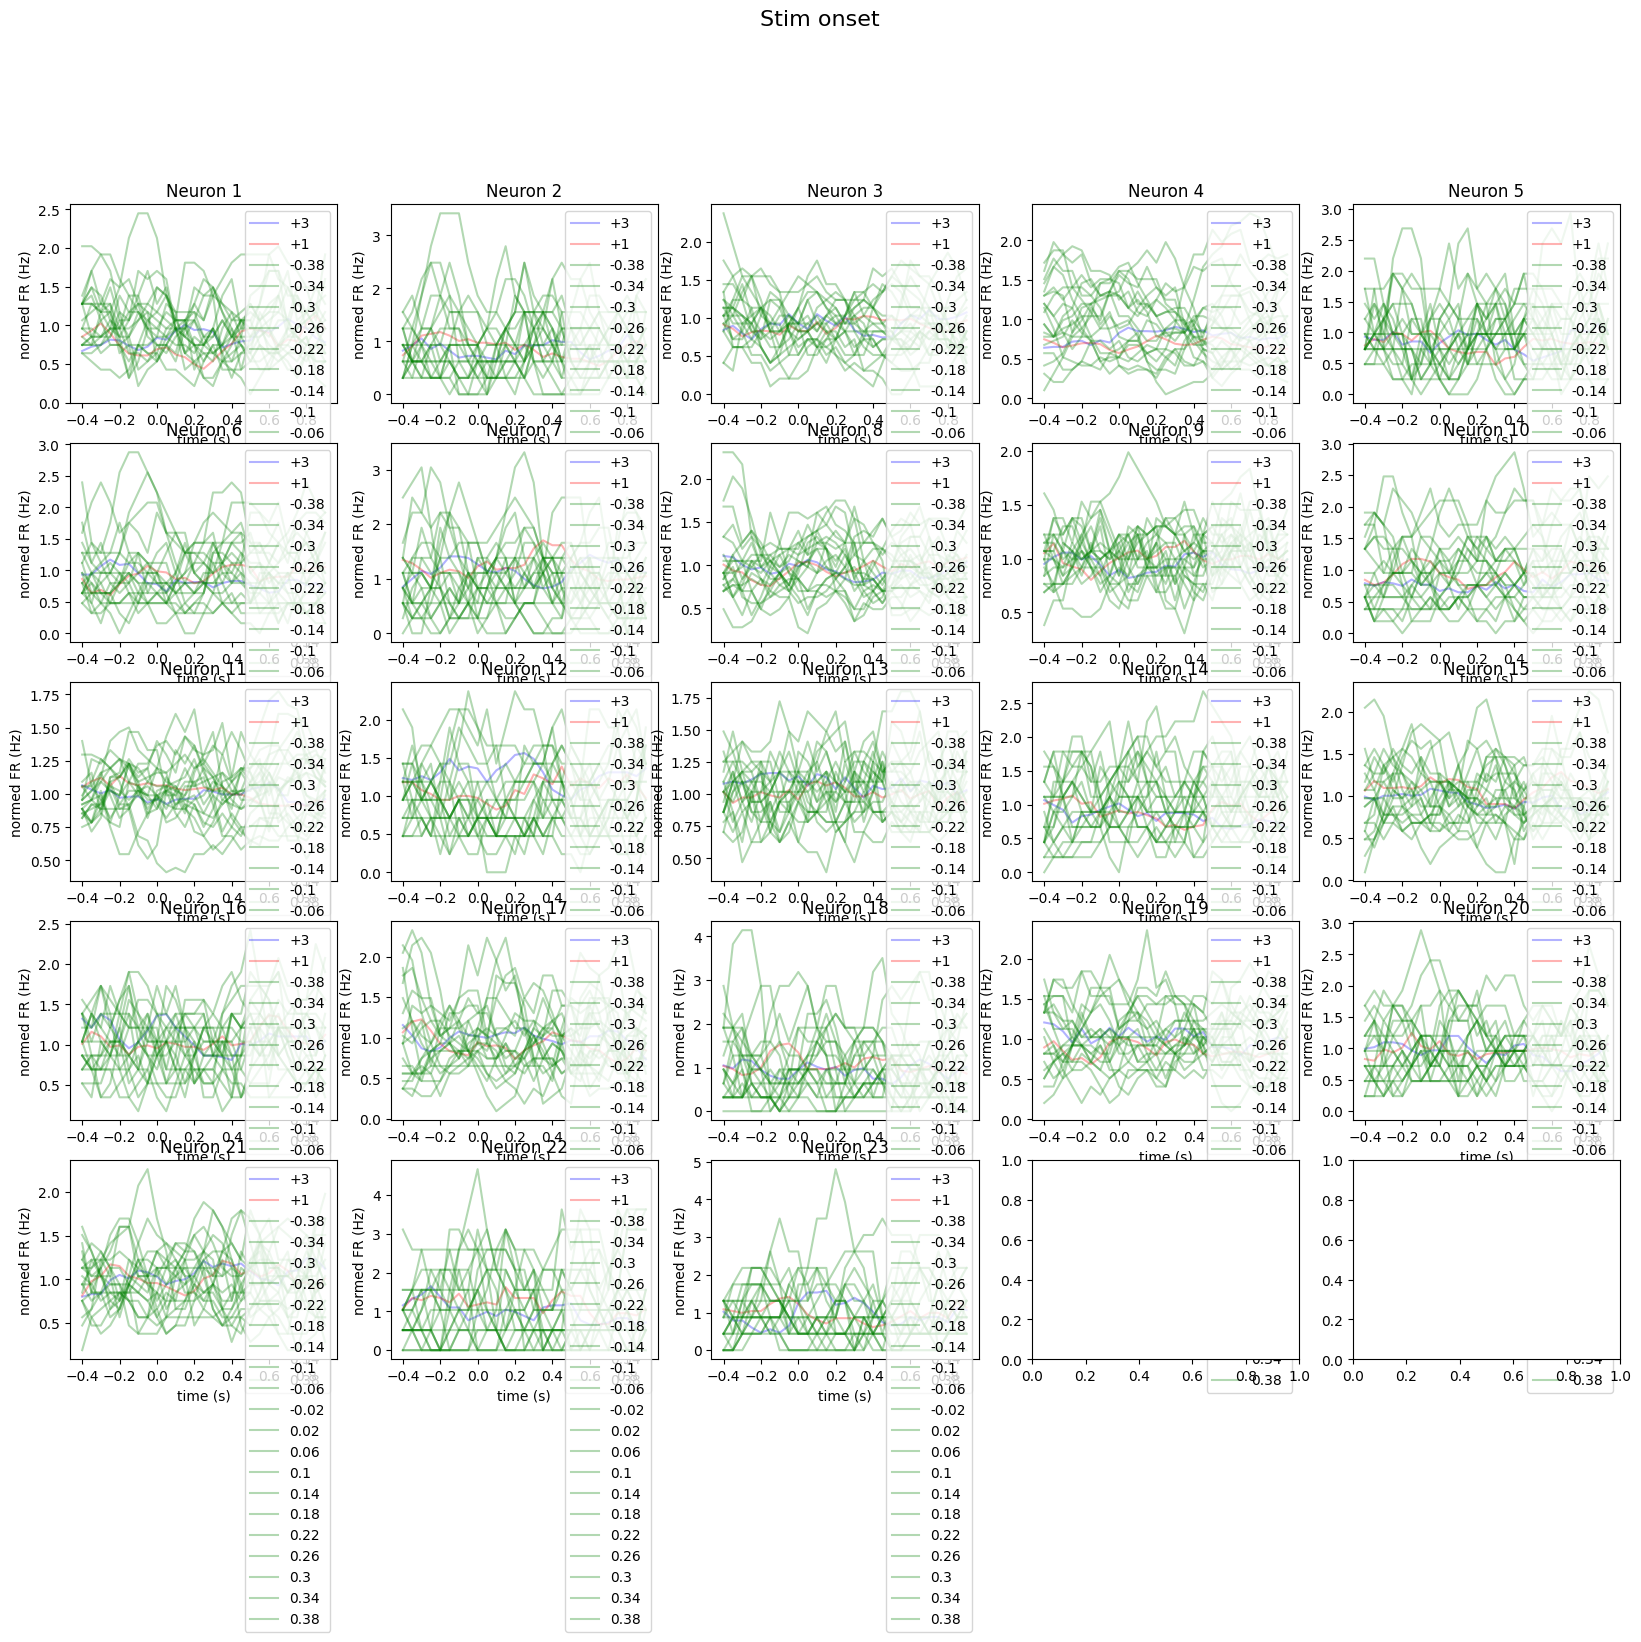

In [51]:
n_rows, n_cols = 5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):
    for outcome, outcome_FRs, color in zip(['+3', '+1'], [out3_FRs, out1_FRs], ['b', 'r']):
        axs[ax].plot(bin_mid_pts, outcome_FRs[neur_i, :], alpha=0.3, color=color, label=outcome)
    for stimVal, stimVal_FRs in stimVal2FRs.items():
        axs[ax].plot(bin_mid_pts, stimVal_FRs[neur_i, :], alpha=0.3, color='g', label=stimVal)
    # axs[ax].axvline(-.25, color='k', linestyle=':', alpha=0.5, label='choice')
    # axs[ax].axvline(0, color='k', linestyle='-', alpha=0.5, label='feedback')
    axs[ax].set(title=f'Neuron {neur_i+1}', ylabel='normed FR (Hz)', xlabel='time (s)', xticks=bin_mid_pts)
    axs[ax].set_xticks(bin_mid_pts[::4]) # sparse
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle('Stim onset', y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# trial x neuron x bin
FR_pos = outcome_FRs_normed[pos_out_ids, :, :]  # +3 trials
FR_neg = outcome_FRs_normed[neg_out_ids, :, :]  # +1 trials

# average in a post-feedback window, e.g. 0–0.5 s
post_mask = (bin_mid_pts >= 0) & (bin_mid_pts <= 0.5)
mean_pos = FR_pos[:, :, post_mask].mean(axis=(0,2))  # shape = (neurons,)
mean_neg = FR_neg[:, :, post_mask].mean(axis=(0,2))

mod_index = (mean_pos - mean_neg) / (mean_pos + mean_neg + 1e-9)
print(mod_index)


[ 0.12247342  0.00525649 -0.03176332  0.10054462  0.09161729 -0.09797716
 -0.13640908 -0.02881495 -0.05573928 -0.1175863  -0.02146329  0.09144543
  0.02335963  0.04525448 -0.04612929  0.01747819  0.04914934 -0.10341489
  0.06522626  0.02380566  0.04108977 -0.13105624  0.19811761]


In [ ]:
from scipy.stats import ttest_ind

p_vals = []
for b in range(n_bins):
    vals_pos = FR_pos[:, :, b].mean(axis=0)  # mean across trials, per neuron
    vals_neg = FR_neg[:, :, b].mean(axis=0)
    t, p = ttest_ind(vals_pos, vals_neg)
    p_vals.append(p)
p_vals = np.array(p_vals)


In [ ]:
from scipy.stats import ttest_ind

FR = outcome_FRs_normed  # shape: trials x neurons x bins
FR_pos, FR_neg = FR[pos_out_ids, :, :], FR[neg_out_ids, :, :]
p_neur_bin = np.ones((FR.shape[1], FR.shape[2]))

for i in range(FR.shape[1]):
    for b in range(FR.shape[2]):
        _, p = ttest_ind(FR_pos[:, i, b], FR_neg[:, i, b], equal_var=False)
        p_neur_bin[i, b] = p


In [ ]:
# bin edges from centers (for axvspan)
bin_edges = np.r_[bin_mid_pts - size/2, bin_mid_pts[-1] + size/2]

# inside your for-neuron plotting loop:
sig = p_neur_bin[neur_i, :] < 0.05
for b in np.where(sig)[0]:
    axs[ax].axvspan(bin_edges[b], bin_edges[b+1], color='k', alpha=0.12, lw=0)


### duration checks for stim & feedback

In [ ]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()

In [ ]:
# print(np.max(df_subj['RT']))
# dur = 475 # movie lasts 475 s

# # gaussian params
# kernel_sd, dt = 1.5, .5 # kinda like bin_size and step
# kernel_sd, dt = 5, .5 # kinda like bin_size and step
# n_bins = int(dur / dt)
# gauss_smooths = []

# # no-overlap boxcar param
# win_size = 1
# boxcar_smooths = []

# for spikes in df_subj['trial_aligned_spikes']:
    
#     # 1. gaussian filter

#     t_gauss = np.arange(0, dur, dt)
#     spike_train = np.zeros_like(t_gauss)
    
#     # bin spikes
#     inds = (np.array(spikes) / dt).astype(int) # what bins does each spikes fall into?
#     inds = inds[inds < len(t_gauss)]
#     spike_train[inds] = 1

#     gauss_smooth = gaussian_filter1d(spike_train, sigma=kernel_sd/dt) / dt
#     gauss_smooths.append(gauss_smooth)

#     # # norm
#     # mean, sd = np.nanmean(gauss_smooth), np.nanstd(gauss_smooth)
#     # gauss_normed = (gauss_smooth - mean) / sd if sd > 0 else gauss_smooth 
#     # gauss_smooths.append(gauss_normed)


#     # 2. boxcar filter

#     t_box = np.arange(0, dur, win_size)
#     boxcar_smooth = []
    
#     for i in np.arange(0, dur-win_size+win_size, win_size):
#         boxcar_smooth.append(len(spikes[(spikes >= i) & (spikes < i + win_size)]))
#     boxcar_smooths.append(boxcar_smooth)

#     # # norm
#     # mean, sd = np.nanmean(boxcar_smooth), np.nanstd(boxcar_smooth)
#     # boxcar_normed = (boxcar_smooth - mean) / sd if sd > 0 else boxcar_smooth
#     # boxcar_smooths.append(boxcar_normed)

# df_subj['gauss_smooths'] = gauss_smooths
# df_subj['boxcar_smooths'] = boxcar_smooths

# num_neurs = 5
# fig, axs = plt.subplots(num_neurs, 3, figsize=(15, 2 * num_neurs))
# axs, ax = axs.flatten(), 0

# for region, region_df in df_subj.groupby('region'):

#     # raster
#     axs[ax].eventplot(region_df['trial_aligned_spikes'].iloc[0], color='black')
#     axs[ax].set_title(f'raster: {region} neuron')
#     axs[ax].set_xlabel('time (s)')
#     ax += 1
    
#     # gauss smooth
#     axs[ax].plot(t_gauss, region_df['gauss_smooths'].iloc[0], color='blue')
#     axs[ax].set_title(f'Gaussian spikes: {region} neuron')
#     axs[ax].set_xlabel('time (s)')
#     axs[ax].set_ylabel('normed FR')
#     ax += 1

#     # boxcar smooth
#     axs[ax].plot(t_box, region_df['boxcar_smooths'].iloc[0], color='blue')
#     axs[ax].set_title(f'Boxcar spikes: {region} neuron')
#     axs[ax].set_xlabel('time (s)')
#     axs[ax].set_ylabel('normed FR')
#     ax += 1

# plt.tight_layout()
# plt.show()